In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

from matplotlib import rcParams
matplotlib.rcParams.update({'font.size': 10})
pd.options.display.max_columns = 30

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
train = pd.read_csv('train.csv')
train.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [4]:
test = pd.read_csv('test.csv')
test.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B


In [5]:
train.shape

(10000, 20)

In [6]:
test.shape

(5000, 19)

#### Приведение типов данных

In [7]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [9]:
train['Id'].dtype

dtype('int64')

In [10]:
test['Id'].dtype

dtype('int64')

In [11]:
train['Id'] = train['Id'].astype(str)
train['Id'].dtype

dtype('O')

In [12]:
test['Id'] = test['Id'].astype(str)
test['Id'].dtype

dtype('O')

In [13]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [14]:
test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Что не нравится и хотелось бы скорректировать:

1. приведение категориальных признаков Ecology_2, Ecology_3, Shops_2 в бинарные
* некорректные значения HouseYear в train
* недостаток данных Healthcare_1
* недостаток данных LifeSquare
* max KitchenSquare выглядит слишком большим в обоих датасетах
* max LifeSquare выглядит слишком большим в train
* min LifeSquare выглядит слишком малым в обоих датасетах

Что касается площадей - в моем понимании Square > KitchenSquare + LifeSquare. Исходя из этой логики в дальнейшем будем пытаться скорректировать значения в датасетах

#### 1. Приведение категориальных признаков Ecology_2, Ecology_3, Shops_2 в бинарные
Проверим количество возможных значений в категориальных признаках Ecology_2, Ecology_3, Shops_2 датасета train:

In [15]:
print(train['Ecology_2'].value_counts()) 
print(train['Ecology_3'].value_counts()) 
print(train['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


Т.к. каждый из категориальных признаков Ecology_2, Ecology_3, Shops_2 содержит только два варианта значений (A или B), то мы можем оставить только одно из них, которое будет соответствовать '1', а '0' будет соответствовать другому варианту. Заметим также, что в этих признаках нет пропусков.

In [16]:
train = pd.concat([train, 
                   pd.get_dummies(pd.DataFrame({'Ecology_2':train['Ecology_2'], 
                                                'Ecology_3':train['Ecology_3'], 
                                                'Shops_2':train['Shops_2']}), 
                                  prefix=['Ecol_2', 'Ecol_3', 'Shops_2'], 
                                  prefix_sep='_', 
                                  drop_first=True, 
                                  dtype='int64')
                  ], axis=1)
train.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644,1,1,1


In [17]:
train.shape

(10000, 20)

Аналогично проверим количество возможных значений в категориальных признаках Ecology_2, Ecology_3, Shops_2 датасета test, а также убедимся в отсутствии пропусков, и проведем те же манипуляции над датасетом для приведения названных признаков в бинарные:

In [18]:
print(test['Ecology_2'].value_counts()) 
print(test['Ecology_3'].value_counts()) 
print(test['Shops_2'].value_counts())

B    4952
A      48
Name: Ecology_2, dtype: int64
B    4851
A     149
Name: Ecology_3, dtype: int64
B    4588
A     412
Name: Shops_2, dtype: int64


In [19]:
test = pd.concat([test, 
                   pd.get_dummies(pd.DataFrame({'Ecology_2':test['Ecology_2'], 
                                                'Ecology_3':test['Ecology_3'], 
                                                'Shops_2':test['Shops_2']}), 
                                  prefix=['Ecol_2', 'Ecol_3', 'Shops_2'], 
                                  prefix_sep='_', 
                                  drop_first=True, 
                                  dtype='int64')
                  ], axis=1)
test.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecol_2_B,Ecol_3_B,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,NaN,0,0,1,1,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,6,1437,3,NaN,0,2,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,NaN,3,3,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,1,NaN,0,0,1,1,0


In [20]:
test.shape

(5000, 19)

#### 2. Исправим значение HouseYear в датасете train

In [21]:
train.loc[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,30,6141,10,262.0,3,6,254084.534396,1,1,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,25,4756,16,2857.0,5,8,243028.603096,1,1,1


Из предыдущего вывода видно 2 выброса c DistrictId 109 и 147. Т.к. это всего два значения, они не должны оказать сильного влияния на обучение, но, тем не менее являются выбросами. Предположу замену HouseYear в первом случае на 2011, а во втором на 1968.

In [22]:
train.loc[(train['HouseYear'] == 20052011), 'HouseYear'] = 2011
train.loc[(train['HouseYear'] == 4968), 'HouseYear'] = 1968
pd.concat([train.loc[1497:1497,:], train.loc[4189:4189,:]], axis=0)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecol_2_B,Ecol_3_B,Shops_2_B
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,2011,0.136330,30,6141,10,262.0,3,6,254084.534396,1,1,1
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,1968,0.319809,25,4756,16,2857.0,5,8,243028.603096,1,1,1


#### 3. Заполним недостающие данные Healthcare_1

In [23]:
# рассмотрим таблицу корреляций признака Healthcare_1
train.corr()[['Healthcare_1']]

,Healthcare_1
DistrictId,0.304335
Rooms,0.042857
Square,-0.039748
LifeSquare,-0.026867
KitchenSquare,0.009472
Floor,-0.138294
HouseFloor,-0.143973
HouseYear,-0.205527
Ecology_1,-0.043547
Social_1,0.077133


Исходя из предыдущей таблицы и сведений о признаках предположу, что признак Healthcare_1 зависит от (в порядке убывания):
 - DistrictId
 - Social_1
 - Social_2
 - Social_3
 - Helthcare_2

##### Здесь начинался мой "велосипед"

##### Здесь закончился мой "велосипед"

Заполняем пропуски Healthcare_1

In [24]:
def ident_model(train_df):
    model_1 = RandomForestClassifier(max_depth=16)
    train_ = train_df[train_df['Healthcare_1'].isna() == False][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    tr, tst = train_test_split(train_, test_size = 0.16, random_state = 29)
    model_1.fit(tr.drop('Healthcare_1', axis = 1), tr['Healthcare_1'])
    pred = model_1.predict(tst.drop('Healthcare_1', axis = 1))
    print(accuracy_score(tst['Healthcare_1'], pred))
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    model_1.fit(train_.drop('Healthcare_1', axis = 1), train_['Healthcare_1'])
    pred = model_1.predict(test_.drop('Healthcare_1', axis = 1))
    return model_1


def fill_H1(model_1, train_df):
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1','Social_2', 'Social_3', 'Helthcare_2','Healthcare_1']]
    pred = model_1.predict(test_.drop('Healthcare_1', axis = 1))
    return pred

In [25]:
model_1 = ident_model(train)
pred = fill_H1(model_1, train)

1.0


In [26]:
# заполняем пропуски в тренировочном датасете
train.loc[train['Healthcare_1'].isna(), 'Healthcare_1'] = pred
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Price               0
Ecol_2_B            0
Ecol_3_B            0
Shops_2_B           0
dtype: int64

In [27]:
# заполняем тестовый датасет
predict_test_H1 = fill_H1(model_1, test)
test.loc[test['Healthcare_1'].isna(), 'Healthcare_1'] = predict_test_H1
test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Ecol_2_B            0
Ecol_3_B            0
Shops_2_B           0
dtype: int64

#### 4. Заполним недостающие данные LifeSquare

In [28]:
# заполняем LifeSquare как (Square - KitchenSquare) * (медиану отношения LifeSquare/(Square - KitchenSquare) для Square > LifeSquare
def fill_LifeSquare(train_df):
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'LifeSquare'] = \
    (train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'Square'] - \
    train_df.loc[(train_df['Square'] < train_df['LifeSquare']) | (train_df['LifeSquare'].isna()), 'KitchenSquare']) * \
    (train_df.loc[(train_df['Square'] > train_df['LifeSquare']), 'LifeSquare'] / \
    (train_df.loc[(train_df['Square'] > train_df['LifeSquare']), 'Square'] - \
    train_df.loc[(train_df['Square'] > train_df['LifeSquare']), 'KitchenSquare'])).median()
    return train_df

In [29]:
# заполняем пропуски в тренировочном датасете
train = fill_LifeSquare(train)
train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Price            0
Ecol_2_B         0
Ecol_3_B         0
Shops_2_B        0
dtype: int64

In [30]:
# аналогично для тестового датасета
test = fill_LifeSquare(test)
test.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Ecol_2_B         0
Ecol_3_B         0
Shops_2_B        0
dtype: int64

#### 5. Прогнозирование

             name     value
2          Square  0.386467
9        Social_1  0.143795
1           Rooms  0.079308
10       Social_2  0.053000
11       Social_3  0.051900
0      DistrictId  0.041726
8       Ecology_1  0.039964
7       HouseYear  0.036367
3      LifeSquare  0.032848
12   Healthcare_1  0.032367
5           Floor  0.026934
4   KitchenSquare  0.025887
6      HouseFloor  0.023778
14        Shops_1  0.015819
13    Helthcare_2  0.008032
16       Ecol_3_B  0.000717
17      Shops_2_B  0.000696
15       Ecol_2_B  0.000394
[0.7282216917808191, 0.730513455171039, 0.7322100477745241, 0.7309914070219651, 0.7336396779541625, 0.7327870559084553, 0.7323800634750162, 0.7313876947757689]
0.7336396779541625


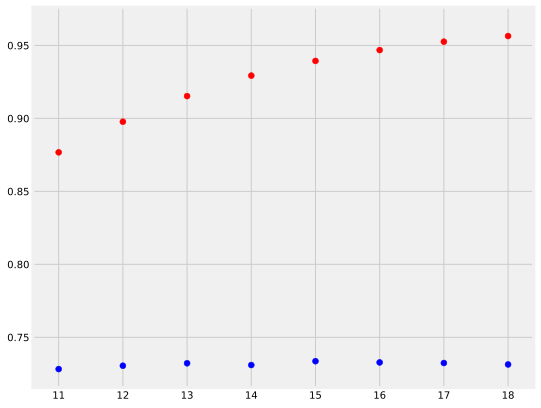

In [31]:
# Со всеми признаками
rcParams['figure.figsize'] = 8, 7

X_train, X_test, y_train, y_test = train_test_split(train.drop(['Id','Price'], axis = 1), 
                                                    train['Price'], test_size = 0.16, random_state = 29)

r2_train = []
r2_test = []
max_depth = list(range(11,19))
for i in max_depth:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=220)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value' , ascending = False))
print(r2_test)
print(max(r2_test))
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
plt.grid(True)

             name     value
2          Square  0.394375
8        Social_1  0.146904
1           Rooms  0.075622
10       Social_3  0.061873
9        Social_2  0.056057
0      DistrictId  0.045547
7       Ecology_1  0.044983
6       HouseYear  0.041092
3      LifeSquare  0.037395
11   Healthcare_1  0.035509
5           Floor  0.031778
4   KitchenSquare  0.028865
[0.7282502832498907, 0.7285728264818747, 0.7252490458521188, 0.7312031154741602, 0.7315902420544773, 0.7312318261831088, 0.72992771939063, 0.7278960314889806]
0.7315902420544773


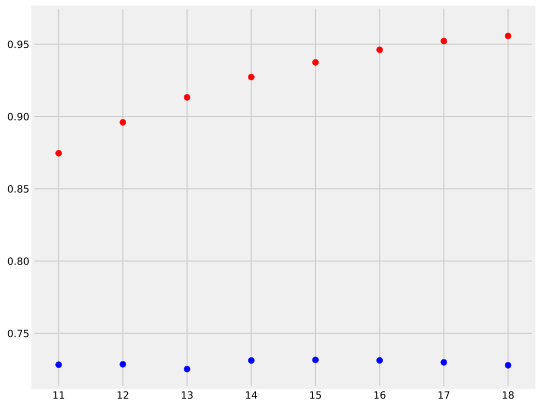

In [32]:
# Удаляем признаки с наименьшей важностью
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Id', 'Price', 'Ecol_2_B', 'Shops_2_B', 'Ecol_3_B', 
                                                                'Helthcare_2', 'Shops_1', 'HouseFloor'], 
                                                               axis = 1), 
                                                    train['Price'], test_size = 0.16, random_state = 29)

r2_train = []
r2_test = []
max_depth = list(range(11,19))
for i in max_depth:
    mod1 = RandomForestRegressor(max_depth=i, n_estimators=220)
    mod1.fit(X_train,y_train)
    pr_train = mod1.predict(X_train)
    pr_test = mod1.predict(X_test)
    r2_train.append(r2(y_train, pr_train))
    r2_test.append(r2(y_test, pr_test))
    
imp = pd.DataFrame()
imp['name'] = X_train.columns
imp['value'] = mod1.feature_importances_
print(imp.sort_values('value' , ascending = False))
print(r2_test)
print(max(r2_test))
plt.scatter(max_depth, r2_train, c ='r')
plt.scatter(max_depth, r2_test, c = 'b')
plt.grid(True)

### Обучение модели на всех данных и итоговое предсказание

In [34]:
model = RandomForestRegressor(max_depth=15, n_estimators=220)
model.fit(train.drop(['Id', 'Price'], axis = 1) , train['Price'] )

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=220, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [35]:
# Делаем предсказание
itog_predict = model.predict(test.drop(['Id'], axis = 1))

In [36]:
test['Price'] = itog_predict

In [37]:
test[['Id', 'Price']].to_csv('rfr_full_model_rev01.csv', index = False)

In [38]:
imp = pd.DataFrame()
imp['name'] = test.drop(['Id','Price'], axis = 1).columns
imp['value'] = model.feature_importances_
print(imp.sort_values('value' , ascending = False))

             name     value
2          Square  0.395345
10       Social_2  0.097315
9        Social_1  0.096065
1           Rooms  0.083538
11       Social_3  0.055965
0      DistrictId  0.042158
8       Ecology_1  0.038439
7       HouseYear  0.034365
3      LifeSquare  0.031456
12   Healthcare_1  0.029910
5           Floor  0.025464
4   KitchenSquare  0.024090
6      HouseFloor  0.021364
14        Shops_1  0.016321
13    Helthcare_2  0.006757
17      Shops_2_B  0.000662
16       Ecol_3_B  0.000403
15       Ecol_2_B  0.000383
